In [1]:
import os
import cv2
import numpy as np
import mediapipe
from numpy import expand_dims
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from matplotlib import pyplot
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
drawingModule = mediapipe.solutions.drawing_utils
handsModule = mediapipe.solutions.hands

In [3]:
# Extracting hand landmarks from a image if possible
# Return format [Success, landmarks]
# Success = boolean value denoting if extraction is successful or not
# Landmarks = 21 point 3D landmarks of the hand or none if hand not detected

def get_landmarks(img):
    with handsModule.Hands(static_image_mode=True, 
                           min_detection_confidence=0.65, 
                           min_tracking_confidence=0.65, 
                           max_num_hands=1) as hands:
        #converting bgr image to rgb before conversion.
        results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        #if landmarks is detected, extract landmarks
        if results.multi_hand_landmarks != None:
            for handLandmarks in results.multi_hand_landmarks:
                points = [] 
                #extracting landmarks into a list
                for point in handsModule.HandLandmark:
                    normalizedLandmark =  handLandmarks.landmark[point]
                    pt = [normalizedLandmark.x, normalizedLandmark.y, normalizedLandmark.z]
                    points.append(pt)
                
                #returning normalised landmarks.
                return True, np.array(points, dtype = 'float64')
        else:
            #failed to capture landmarks from the image
            return False, None

In [4]:
def create_augment_iter(img):
    samples = expand_dims(img, 0)
    datagen = ImageDataGenerator(width_shift_range=[-30,30],
                            height_shift_range=0.2,
                            rotation_range=30,
                            brightness_range=[0.4,1.4],
                            zoom_range=0.3,
                            fill_mode='nearest')
    it = datagen.flow(samples, batch_size=1)
    return it

In [5]:
path = r"datasets"
y_labels = os.listdir(path)

In [6]:
a_path = os.path.join(path, y_labels[0])
num_images = len(os.listdir(a_path))

100.jpg
(480, 480, 3) uint8


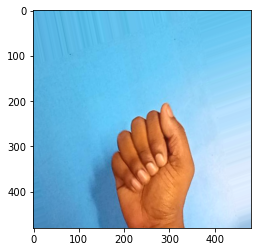

In [7]:
img = os.listdir(a_path)[2]
print(img)
img = cv2.imread(os.path.join(a_path, img))


itr = create_augment_iter(img)
img = itr.next()
img = img[0].astype('uint8')

print(img.shape, img.dtype)
ret, landmarks = get_landmarks(img)

pyplot.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#print(format(landmarks[0][0], 'f'), format(landmarks[0][1], 'f'), format(landmarks[0][2], 'f'))

In [ ]:
x_data = []
y_data = []

success = 0
fail = 0


n_cat = []

for alphabet in y_labels:
    alphabet_path = os.path.join(path, alphabet)
    #print(alphabet_path)
    total = 0
    
    #looping through every image in each category
    for image in tqdm(os.listdir(alphabet_path), desc = alphabet):
        n_expand = 3
        max_loss = 20
        img = cv2.imread(os.path.join(alphabet_path, image))
        
        if(type(img) is not np.ndarray):
            continue
            
        itr = create_augment_iter(img)        
        
        while(n_expand != 0 and max_loss != 0):
            img = itr.next()
            img = img[0].astype('uint8')
            
            ret, landmarks = get_landmarks(img)
            total += 1
            if ret:
                x_data.append(landmarks.reshape(7,9))
                y_data.append(alphabet)
                #count = count + 1
                n_expand -= 1
                success += 1
            else:
                fail += 1
                max_loss -= 1
        #clear_output()
    n_cat.append(total)

A:  12%|█████████▎                                                                  | 368/3000 [02:49<14:48,  2.96it/s]

In [ ]:
x_dat = np.array(x_data)
y_dat = np.array(y_data)

In [ ]:
print(n_cat)

In [ ]:
print(x_dat.shape)
print(y_dat.shape)

In [ ]:
np.save("x_data", x_dat)
np.save("y_data", y_dat)